In [92]:
import numpy as np
from sklearn.linear_model import LinearRegression
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import math

#A function to calculate Root Mean Squared Logarithmic Error (RMSLE)
def rmsle(y, y_pred):
    assert len(y) == len(y_pred)
    terms_to_sum = [(math.log(y_pred[i] + 1) - math.log(y[i] + 1)) ** 2.0 for i,pred in enumerate(y_pred)]
    return (sum(terms_to_sum) * (1.0/len(y))) ** 0.5

pd.options.display.max_columns = 1000
pd.options.display.max_rows = 1000

In [46]:
# Plot Functions
SMALL_SIZE = 8
MEDIUM_SIZE = 8
BIGGER_SIZE = 10

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=SMALL_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=MEDIUM_SIZE)  # fontsize of the figure title

In [47]:
# Basic EDA
train_data = pd.read_csv('train.csv')

# Labels
train_labels = train_data.loc[:,'SalePrice']

# Dummify for now
original_data = train_data.copy()
train_data = pd.get_dummies(train_data)

# Data
split = 200
train_data = train_data.drop('SalePrice', axis = 1)

# Split train data and dev Data
dev_data = train_data[:split]
train_data = train_data[split:]
dev_labels = train_labels[:split]
train_labels = train_labels[split:]

# Test data
test_data = pd.read_csv('test.csv')

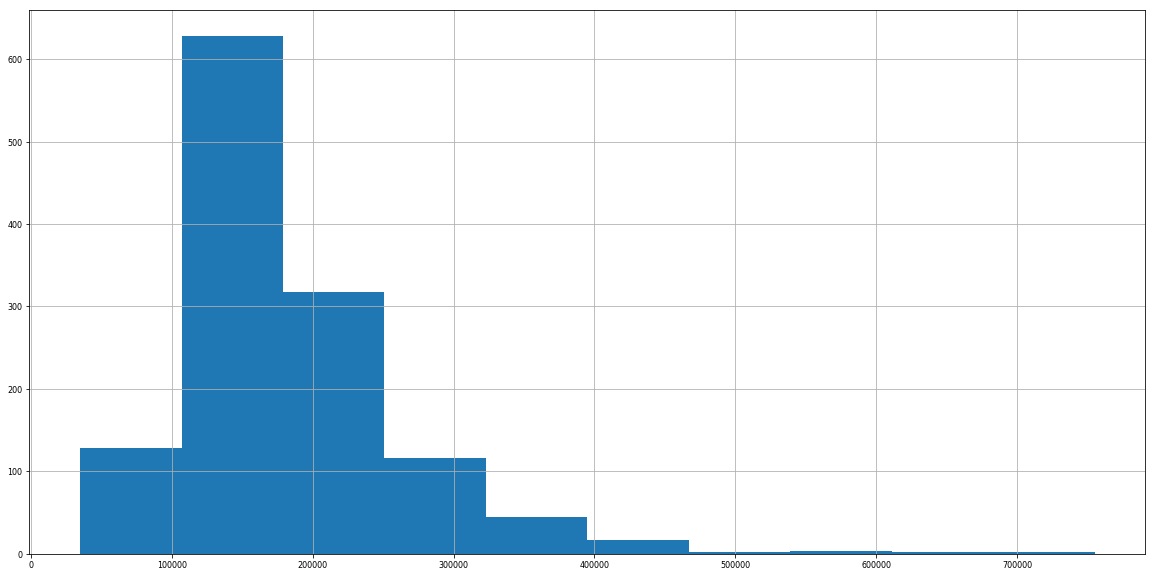

In [48]:
plt.figure(figsize=(20,10))
train_labels.hist()

In [49]:
# Basic Descriptions on all variables

# Numeric 
train_data.describe(include=[np.number]).transpose()
pd.DataFrame(original_data.columns.values).to_csv('colnames.csv')

Lots of continuous variables and categorical ones - and not a lot of data (1460). Will probably not be a linear combination of features - probably some kind of tree-based model?

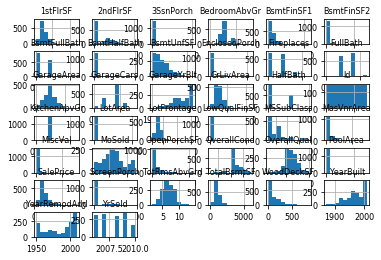

In [50]:
trainhist = original_data.hist()
plt.savefig('./numeric_EDA.pdf')

In [51]:
# Categorical
original_data.select_dtypes(include='object').apply(lambda x: x.value_counts()).T.stack()


MSZoning       C (all)      10.0
               FV           65.0
               RH           16.0
               RL         1151.0
               RM          218.0
Street         Grvl          6.0
               Pave       1454.0
Alley          Grvl         50.0
               Pave         41.0
LotShape       IR1         484.0
               IR2          41.0
               IR3          10.0
               Reg         925.0
LandContour    Bnk          63.0
               HLS          50.0
               Low          36.0
               Lvl        1311.0
Utilities      AllPub     1459.0
               NoSeWa        1.0
LotConfig      Corner      263.0
               CulDSac      94.0
               FR2          47.0
               FR3           4.0
               Inside     1052.0
LandSlope      Gtl        1382.0
               Mod          65.0
               Sev          13.0
Neighborhood   Blmngtn      17.0
               Blueste       2.0
               BrDale       16.0
          

Generally most of the value appear to be OK - not many missing values, but the categories can be fairly unbalanced in some cases (e.g. most "Sale Condition" is normal). 

### Missing Values
Missing values look ok - some easy candidates to remove from our feature set. 

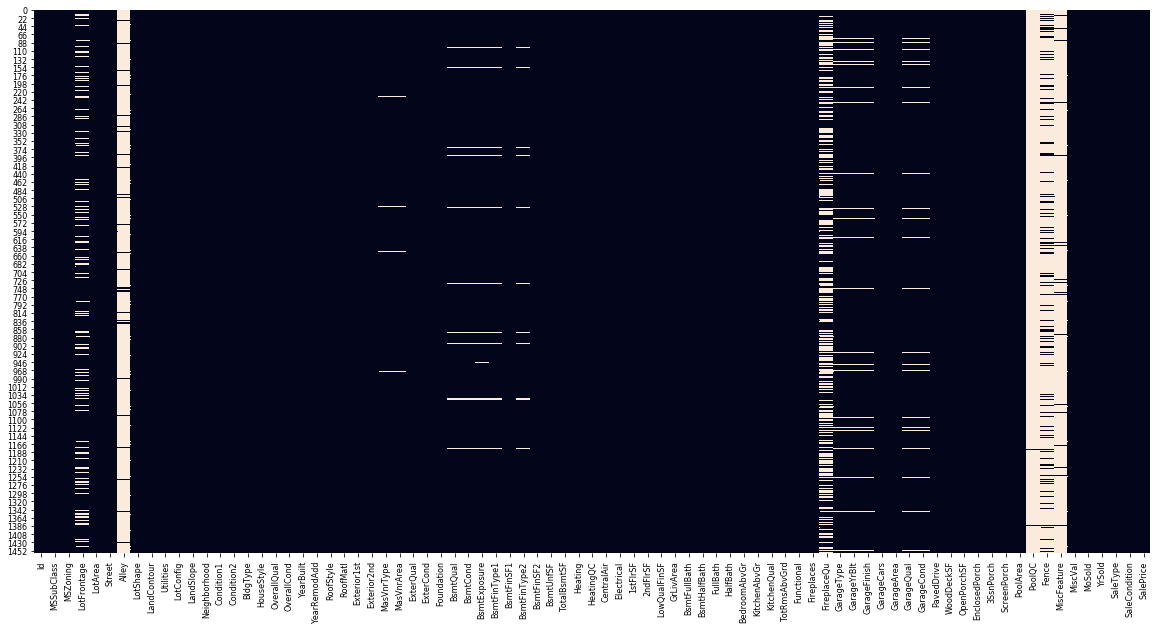

In [52]:
# Missing Values
plt.figure(figsize=(20,10))
sns.heatmap(original_data.isnull(), cbar=False)
plt.savefig('./missing_EDA.pdf')

In [53]:
# Drop these variables that have a lot missing
print(original_data['Alley'].value_counts(dropna = False))
print(original_data['PoolQC'].value_counts(dropna = False))
print(original_data['Fence'].value_counts(dropna = False))
print(original_data['MiscFeature'].value_counts(dropna = False))

newdata = original_data.drop(columns=['Alley', 'PoolQC', 'Fence', 'MiscFeature'])



NaN     1369
Grvl      50
Pave      41
Name: Alley, dtype: int64
NaN    1453
Gd        3
Ex        2
Fa        2
Name: PoolQC, dtype: int64
NaN      1179
MnPrv     157
GdPrv      59
GdWo       54
MnWw       11
Name: Fence, dtype: int64
NaN     1406
Shed      49
Gar2       2
Othr       2
TenC       1
Name: MiscFeature, dtype: int64


### Remove (categorical) features that have a major class imbalance


### Impute means for categorical features

In [61]:
original_data[original_data.isin([np.nan, np.inf, -np.inf])]

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [77]:
from sklearn.impute import SimpleImputer
imp = SimpleImputer(missing_values = np.nan, strategy = 'median')
imp.fit_transform()



array([[1.00000e+00, 6.00000e+01, 6.50000e+01, ..., 2.00000e+00,
        2.00800e+03, 2.08500e+05],
       [2.00000e+00, 2.00000e+01, 8.00000e+01, ..., 5.00000e+00,
        2.00700e+03, 1.81500e+05],
       [3.00000e+00, 6.00000e+01, 6.80000e+01, ..., 9.00000e+00,
        2.00800e+03, 2.23500e+05],
       ...,
       [1.45800e+03, 7.00000e+01, 6.60000e+01, ..., 5.00000e+00,
        2.01000e+03, 2.66500e+05],
       [1.45900e+03, 2.00000e+01, 6.80000e+01, ..., 4.00000e+00,
        2.01000e+03, 1.42125e+05],
       [1.46000e+03, 2.00000e+01, 7.50000e+01, ..., 6.00000e+00,
        2.00800e+03, 1.47500e+05]])

### Remove Features that are highly correlated

In [ ]:
# Correlation matrix
plt.figure(figsize=(20,10))
corr = original_data.select_dtypes(exclude='object').corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

### Use an algorithmic Feature Selection method

In [14]:
original_data.select_dtypes(include='object')

,MSZoning,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,...,GarageType,GarageFinish,GarageQual,GarageCond,PavedDrive,PoolQC,Fence,MiscFeature,SaleType,SaleCondition
0,RL,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,...,Attchd,RFn,TA,TA,Y,NaN,NaN,NaN,WD,Normal
1,RL,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,...,Attchd,RFn,TA,TA,Y,NaN,NaN,NaN,WD,Normal
2,RL,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,...,Attchd,RFn,TA,TA,Y,NaN,NaN,NaN,WD,Normal
3,RL,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,...,Detchd,Unf,TA,TA,Y,NaN,NaN,NaN,WD,Abnorml
4,RL,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,...,Attchd,RFn,TA,TA,Y,NaN,NaN,NaN,WD,Normal
5,RL,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,Mitchel,Norm,...,Attchd,Unf,TA,TA,Y,NaN,MnPrv,Shed,WD,Normal
6,RL,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,Somerst,Norm,...,Attchd,RFn,TA,TA,Y,NaN,NaN,NaN,WD,Normal
7,RL,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,NWAmes,PosN,...,Attchd,RFn,TA,TA,Y,NaN,NaN,Shed,WD,Normal
8,RM,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,OldTown,Artery,...,Detchd,Unf,Fa,TA,Y,NaN,NaN,NaN,WD,Abnorml
9,RL,Pave,NaN,Reg,Lvl,AllPub,Corner,Gtl,BrkSide,Artery,...,Attchd,RFn,Gd,TA,Y,NaN,NaN,NaN,WD,Normal


In [75]:
original_data.select_dtypes(include=[np.number]).describe()

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
count,1460.000000,1460.000000,1201.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1452.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1379.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000
mean,730.500000,56.897260,70.049958,10516.828082,6.099315,5.575342,1971.267808,1984.865753,103.685262,443.639726,46.549315,567.240411,1057.429452,1162.626712,346.992466,5.844521,1515.463699,0.425342,0.057534,1.565068,0.382877,2.866438,1.046575,6.517808,0.613014,1978.506164,1.767123,472.980137,94.244521,46.660274,21.954110,3.409589,15.060959,2.758904,43.489041,6.321918,2007.815753,180921.195890
std,421.610009,42.300571,24.284752,9981.264932,1.382997,1.112799,30.202904,20.645407,181.066207,456.098091,161.319273,441.866955,438.705324,386.587738,436.528436,48.623081,525.480383,0.518911,0.238753,0.550916,0.502885,0.815778,0.220338,1.625393,0.644666,24.689725,0.747315,213.804841,125.338794,66.256028,61.119149,29.317331,55.757415,40.177307,496.123024,2.703626,1.328095,79442.502883
min,1.000000,20.000000,21.000000,1300.000000,1.000000,1.000000,1872.000000,1950.000000,0.000000,0.000000,0.000000,0.000000,0.000000,334.000000,0.000000,0.000000,334.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,0.000000,1900.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000,34900.000000
25%,365.750000,20.000000,59.000000,7553.500000,5.000000,5.000000,1954.000000,1967.000000,0.000000,0.000000,0.000000,223.000000,795.750000,882.000000,0.000000,0.000000,1129.500000,0.000000,0.000000,1.000000,0.000000,2.000000,1.000000,5.000000,0.000000,1961.000000,1.000000,334.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,2007.000000,129975.000000
50%,730.500000,50.000000,69.000000,9478.500000,6.000000,5.000000,1973.000000,1994.000000,0.000000,383.500000,0.000000,477.500000,991.500000,1087.000000,0.000000,0.000000,1464.000000,0.000000,0.000000,2.000000,0.000000,3.000000,1.000000,6.000000,1.000000,1980.000000,2.000000,480.000000,0.000000,25.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000,163000.000000
75%,1095.250000,70.000000,80.000000,11601.500000,7.000000,6.000000,2000.000000,2004.000000,166.000000,712.250000,0.000000,808.000000,1298.250000,1391.250000,728.000000,0.000000,1776.750000,1.000000,0.000000,2.000000,1.000000,3.000000,1.000000,7.000000,1.000000,2002.000000,2.000000,576.000000,168.000000,68.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000,214000.000000
max,1460.000000,190.000000,313.000000,215245.000000,10.000000,9.000000,2010.000000,2010.000000,1600.000000,5644.000000,1474.000000,2336.000000,6110.000000,4692.000000,2065.000000,572.000000,5642.000000,3.000000,2.000000,3.000000,2.000000,8.000000,3.000000,14.000000,3.000000,2010.000000,4.000000,1418.000000,857.000000,547.000000,552.000000,508.000000,480.000000,738.000000,15500.000000,12.000000,2010.000000,755000.000000


In [84]:
original_data_dummy

array([[1.000e+00, 6.000e+01, 6.500e+01, ..., 0.000e+00, 1.000e+00,
        0.000e+00],
       [2.000e+00, 2.000e+01, 8.000e+01, ..., 0.000e+00, 1.000e+00,
        0.000e+00],
       [3.000e+00, 6.000e+01, 6.800e+01, ..., 0.000e+00, 1.000e+00,
        0.000e+00],
       ...,
       [1.458e+03, 7.000e+01, 6.600e+01, ..., 0.000e+00, 1.000e+00,
        0.000e+00],
       [1.459e+03, 2.000e+01, 6.800e+01, ..., 0.000e+00, 1.000e+00,
        0.000e+00],
       [1.460e+03, 2.000e+01, 7.500e+01, ..., 0.000e+00, 1.000e+00,
        0.000e+00]])

In [104]:
from sklearn.datasets import load_boston
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import OneHotEncoder
import numpy as np
from sklearn.impute import SimpleImputer

# Binarize all categorical
original_data_dummy = pd.get_dummies(original_data.drop(['SalePrice'], axis = 1))

# Impute all numeric
imp = SimpleImputer(missing_values = np.nan, strategy = 'median')
original_data_dummy_array = imp.fit_transform(original_data_dummy)

rf = RandomForestRegressor()
rf.fit(original_data_dummy_array, original_data['SalePrice'])
rf.feature_importances_

feature_importances = pd.DataFrame(rf.feature_importances_.round(4),
                                   index = original_data_dummy.columns,
                                    columns=['importance']).sort_values('importance', ascending=False)

feature_importances
# Plot
#feature_importances.nlargest(30,'importance').plot(kind='barh')

/Users/yangweineo/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:248: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


,importance
OverallQual,0.5935
GrLivArea,0.1077
2ndFlrSF,0.0452
TotalBsmtSF,0.0336
1stFlrSF,0.0296
BsmtFinSF1,0.0267
GarageArea,0.0156
GarageCars,0.0119
LotArea,0.0104
FullBath,0.0082


### Keep variables that are highly correlated with the predictor (continuous)

In [ ]:
corr_with_salep = original_data.select_dtypes(exclude='object').drop("SalePrice", axis=1).apply(lambda x: x.corr(original_data.SalePrice))
np.abs(corr_with_salep).sort_values(ascending=False)

# For now I just keep variables that have 0.3 and above correlation

### Identify variables that are highly correlated with the predictor (categorical - use oneway Anova)

In [ ]:
# https://www.marsja.se/four-ways-to-conduct-one-way-anovas-using-python/

### Run a Simple Linear Model

In [ ]:
# New Data
newtrain_data = pd.get_dummies(newdata)

# Data
split = 200
newtrain_data = newtrain_data.drop('SalePrice', axis = 1)

# Split train data and dev Data
dev_newdata = newtrain_data[:split]
train_newdata = newtrain_data[split:]



In [ ]:
linearmodel = LinearRegression()
linearmodel.fit(train_newdata.fillna(0), train_labels)
dev_pred = linearmodel.predict(dev_newdata.fillna(0))

# Mean Abs % Error
print(np.mean(np.abs(dev_pred-dev_labels)/dev_labels))

# RMSLE
rmsle(dev_labels, dev_pred)

In [ ]:
linearmodel.fit(train_data.fillna(0), train_labels)
dev_pred = linearmodel.predict(dev_data.fillna(0))

# Mean Abs % Error
print(np.mean(np.abs(dev_pred-dev_labels)/dev_labels))

# RMSLE
rmsle(dev_labels, dev_pred)

### Run a Random Forest 

In [110]:
# Binarize all categorical
original_data_dummy = pd.get_dummies(original_data.drop(['SalePrice'], axis = 1))

# Impute all numeric
imp = SimpleImputer(missing_values = np.nan, strategy = 'median')
original_data_dummy_array = imp.fit_transform(original_data_dummy)

# Split train data and dev Data
split = 200
dev_rfdata = original_data_dummy_array[:split]
train_rfdata = original_data_dummy_array[split:]

# Run RF
rf = RandomForestRegressor()
rf.fit(train_rfdata, train_labels)
dev_pred = rf.predict(dev_rfdata)

# Mean Abs % Error
print(np.mean(np.abs(dev_pred-dev_labels)/dev_labels))

# RMSLE
rmsle(dev_labels, dev_pred)

/Users/yangweineo/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:248: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


0.12287218487617844


0.16599903273215325